# FastNeuralBursts

In [1]:
# main package FastNeuralBurst

from FastNeuralBursts.spectra import spectra
from FastNeuralBursts.dispersion import dispersion_simulation
from FastNeuralBursts.inference import sbi_inference
import FastNeuralBursts.utils as utils
import FastNeuralBursts.host as host

In [2]:
# additional packages for GLASS

import camb
from cosmology import Cosmology
import glass.shells
import glass.fields
import glass.ext.camb
import numpy as np

#### Variable assignment from config file

Takes the config file (.ini) as input and assigns the variables global variables.

In [3]:
variables_dict = utils.assign_variable()
globals().update(variables_dict)

In [4]:
# variables_dict

In [5]:
sigma8

0.834

#### Read catalogue

Given the file location of the catalogue (.csv) assigns the variables.

In [6]:
z_frb, dm_from_catalogue, dm_milky_way, frb_name, frb_name_label, phi_radians, theta_radians = utils.read_catalogue(path + "catalogue_2.csv")

In [7]:
path

'./Input_files/'

In [8]:
(kmin, kmax, int(n_k))

(1e-05, 100, 200)

#### HM code

Calculates non-linear spectra from linear power spectra using HM code. Use precomputed spectra to save time. 

In [9]:
# z_hm_code = np.geomspace(zet_min, zet_max, int(n_z_interp))
# k_hm_code = np.geomspace(kmin, kmax, int(n_k))
# fbr_spectra_instance = spectra(z_range=z_hm_code, k_range=k_hm_code,
#                           omega_c=omega_c,omega_b=omega_b,h=h,n_s=n_s,sigma8=sigma8,w0=w0, wa=wa, neff=neff, 
#                            log10theta=log10theta, t_cmb=t_cmb, m_nu=m_nu)

# #Call the method on the instance
# P_ee_all, P_mm_all, P_me_all = fbr_spectra_instance.hm_spectra(verbose=True)

In [10]:
# P_ee_all = np.load(path+'P_nl_hm_code.npy')

#### GLASS shells

This is where we define the concentric spherical shells using GLASS. The parameter `NSIDE` controls the resolution of simulation. 

In [11]:
pars = camb.set_params(H0=100*h, omch2=omega_c*h**2, ombh2=omega_b*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
Cosmo = Cosmology.from_camb(pars)
z_edges_for_glass = glass.shells.distance_grid(Cosmo, 0.01, 1., num=int(num))
NSIDE = nside
lmax = 3*NSIDE - 1
ell = np.arange(1, lmax, 1)

#### Levin Code

Calculates the Angular power spctra for the shells. Use precomupted spectra **only** when number of shells is 17

In [12]:
# cls_levin = fbr_spectra_instance.levin_code(ell, P_ee_all, z_edges_for_glass, 
#                                         ell_limber=ell_limber, ell_nonlimber=ell_nonlimber,
#                                         max_number_subintervals=max_number_subintervals, minell=minell, maxell=maxell, 
#                                         n_nonlimber=n_nonlimber, n_limber=n_limber, ninterp=ninterp,
#                                         verbose=True)

In [13]:
cls_levin = np.load(path+'cls_levin_lmax_15000_final_version.npy')

#### Simulating DM

> Main class for simulating Dispersion Measure. <br> Here, we instantiate the class with the corresponding inputs 

In [14]:
simulation_instance = dispersion_simulation(z_edges_for_glass = z_edges_for_glass,
                                            host_model='lognormal',
                                            input_path=path, output_path=output_dir_name, 
                                            cls=cls_levin,
                                             omega_c=omega_c,omega_b=omega_b,h=h, chi_e=chi_e, f_igm = f_igm, 
                                            NSIDE=nside)

/home/koustav/.local/lib/python3.10/site-packages/glass/shells.py:166: UserWarning: first tophat window does not start at redshift zero
  warnings.warn('first tophat window does not start at redshift zero')


Call function on that instance to calculate parameters

In [15]:
import torch
dm_multi_run = simulation_instance.dispersion_measure(pars=torch.Tensor([1, 200, 0.35]),
                                                      num_for_mean = 100,  
                                                      save_data=False)

Simulation counter:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time after 100 run: 15.41 sec, Remaining time: 0.00 sec
Time for 100 sims: 15.57 sec, 0.16 sec/sim


In [16]:
dm_single_realisation = simulation_instance.dispersion_measure(torch.Tensor([1, 200, 0.35]))
print(dm_single_realisation)

[471.3826317  376.62917181 345.99889312 371.77259524 513.49690622
 635.09947639 433.37658925 501.68930084 636.31454239 650.9762118
 539.17869348 750.0660449 ]


#### Inference

> The inference section which requires the access to the simulation instance. <br> Here, we can specify the algorithm, number of simulation and types of neural embedding we prefer.

In [17]:
# simulation_instance = dispersion_simulation(z_edges_for_glass = z_edges_for_glass,
#                                             host_model='lognormal',
#                                             input_path=path, output_path=output_dir_name, 
#                                             cls=cls_levin,
#                                              omega_c=omega_c,omega_b=omega_b,h=h, chi_e=chi_e, f_igm = f_igm, 
#                                             NSIDE=nside,
#                                            verbose=False)

In [18]:
output_dir_name

'./Simulation_Data'

In [19]:
sbi_instance = sbi_inference(simulation_instance=simulation_instance, 
                             file_path='config_SBI_DM_FRB.ini', 
                             output_path=output_dir_name)

First, we run the inference using the _**SBI**_ package

Algorithm: SNPE
lognormal host, using Un-compressed DM


2024-06-26 08:08:43.308316: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 08:08:43.602531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 08:08:44.618442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 112 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Removed no burn in


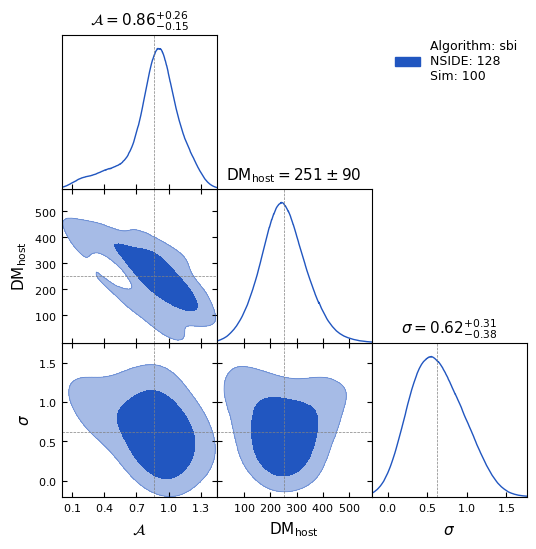

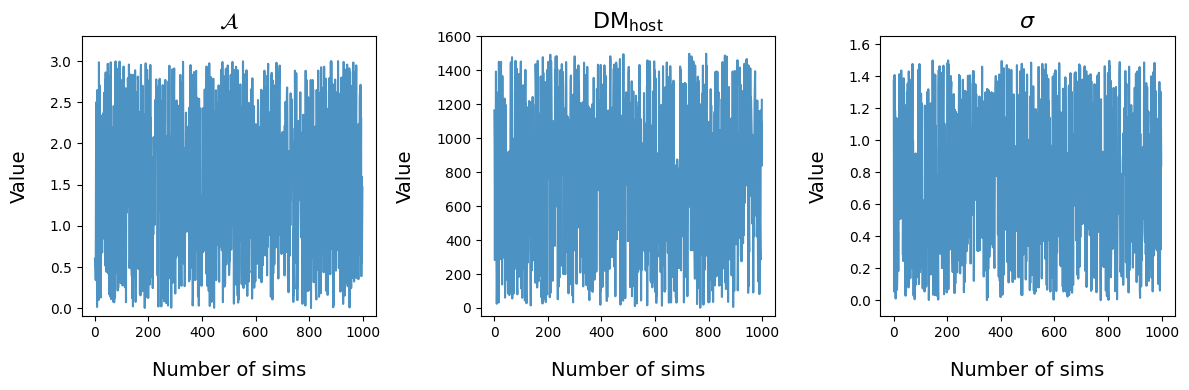

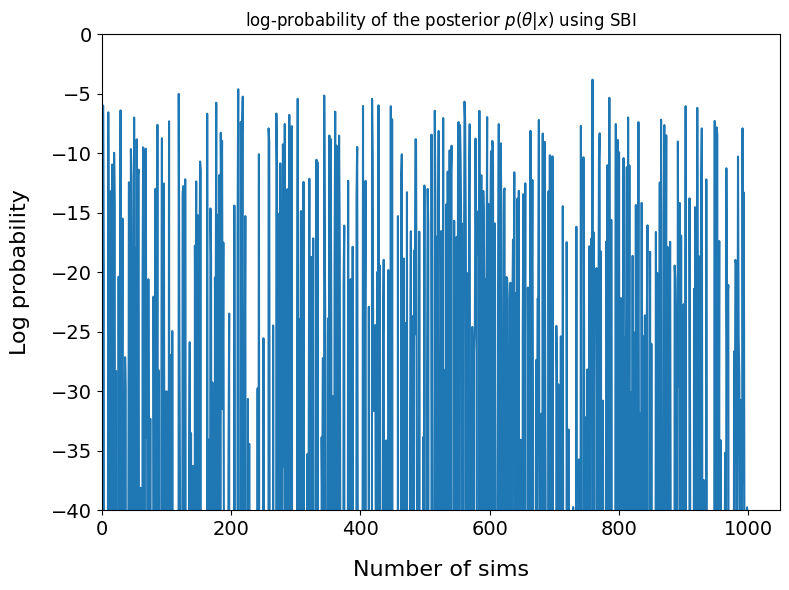



Complete, total time: 177.57 sec


In [20]:
posterior, observation, samples_arr, simulated_data, simulated_theta = sbi_instance.infer(algorithm='SNPE',
                                                                                          num_sample=num_sample, 
                                                                                          num_rounds=num_rounds, 
                                                                                          num_sims_in_round=num_sims_in_round,
                                                                                          num_walkers=num_walkers,
                                                                                          compression=False,
                                                                                          plot_figures=['contour', 'prior', 'likelihood', 'coverage', 'validation'],
                                                                                          save_data=True,
                                                                                          verbose=False)

The log-likelihood minimisation is very noisy. Ideally, we want the blue line to converge to zero. In this example, the plot suggets 
1. we need more simulations, or,
2. we need higher NSIDE value that can account for dispersion measure contribution from smaller scales.

Further, as the noise level remains unchanged throughout the number of sims, option `2` is preferred. <br> We expect <mark>NSIDE $\ge$ 4096</mark> should be the ideal setting. 

Now, we run the inference using the _**iLi**_ package. And this time, we use the `TSNPE` algorithm.

Simulating Data
Algorithm: TSNPE
lognormal host, using Un-compressed DM

Run 1/2


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 78 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Elapsed time after 1 run: 1 min 40 secs, Remaining time: 1 min 40 secs
Run 2/2
The `RestrictedPrior` rejected 73.2%
                of prior samples. You will get a speed-up of
                273.1%.


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 51 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Elapsed time after 2 run: 3 mins 31 secs, Remaining time: 0.00 sec

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]



Complete, total time: 211.54 sec
Device: cuda


/home/koustav/.local/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 44 epochs.

/home/koustav/.local/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Removed no burn in


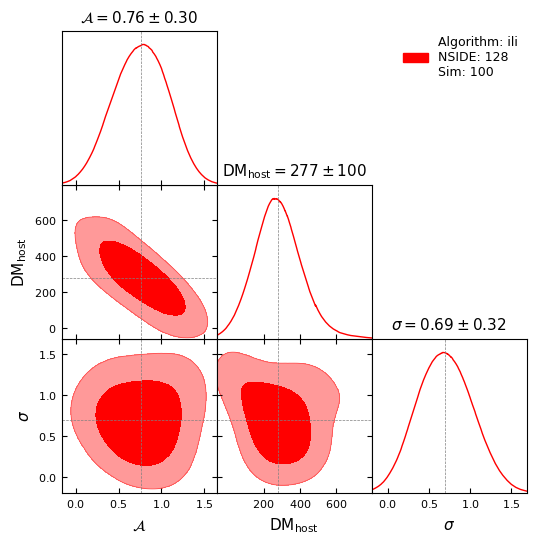

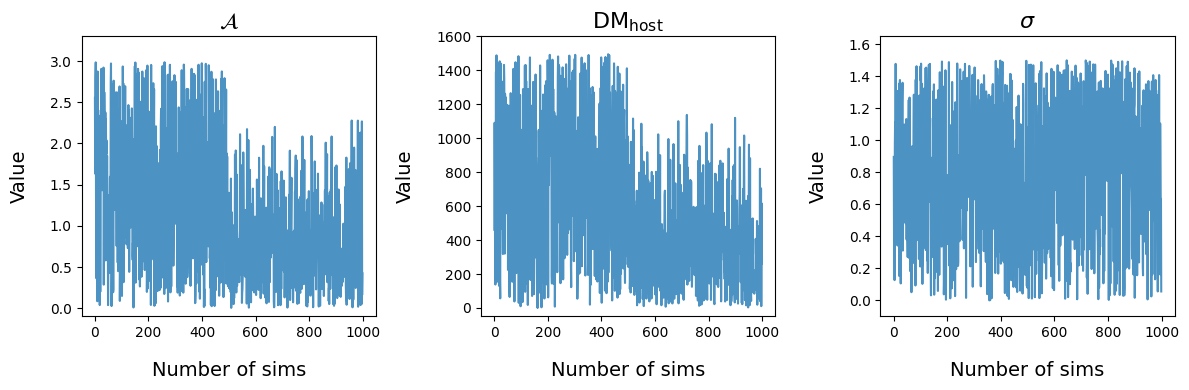



Type Fig: <class 'matplotlib.figure.Figure'>




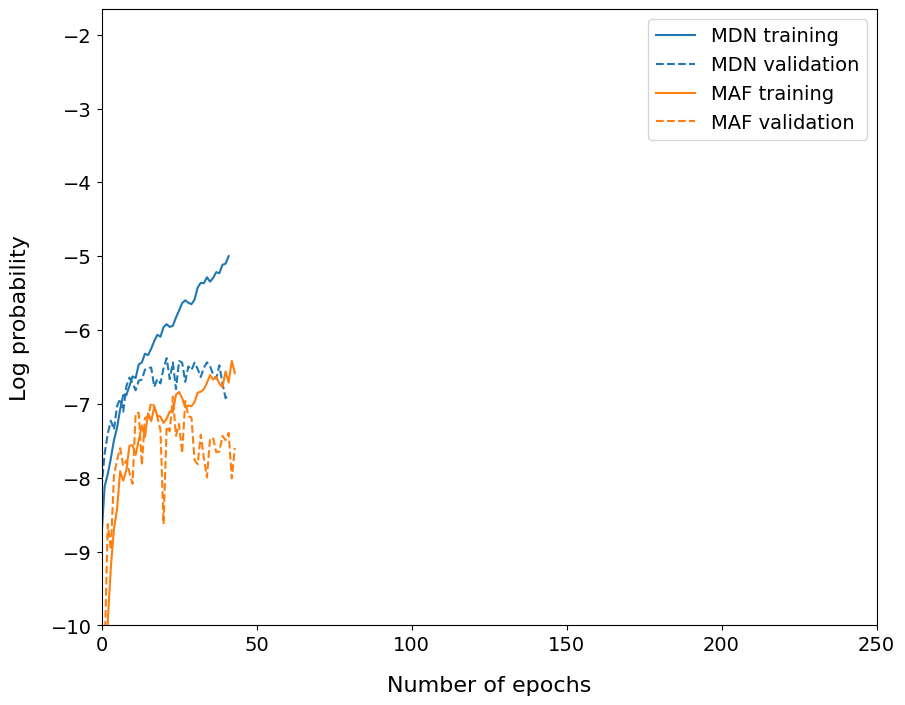

/home/koustav/Python/0000. Public code/FastNeuralBursts/inference.py:179: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  observation = torch.Tensor([observation]).to(device)


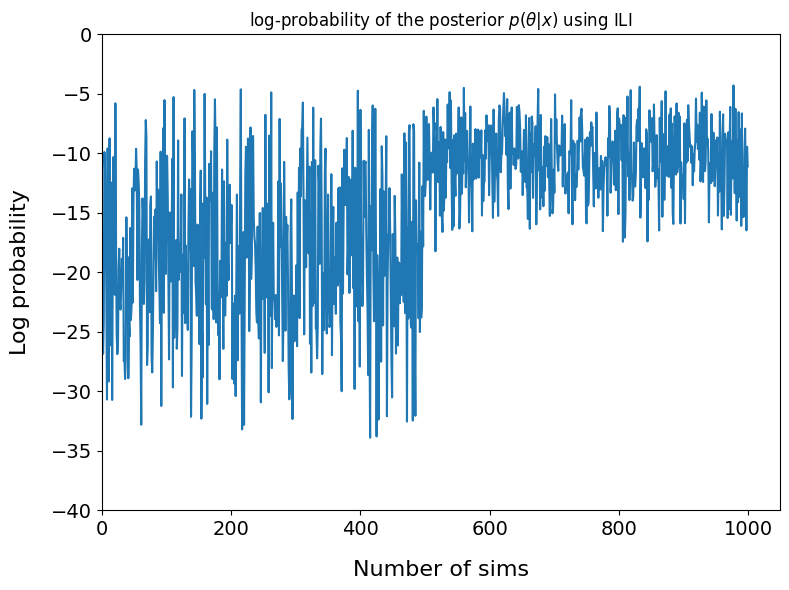

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:48<00:00,  9.25it/s]




Type Fig: (<class 'list'>, <class 'matplotlib.figure.Figure'>)




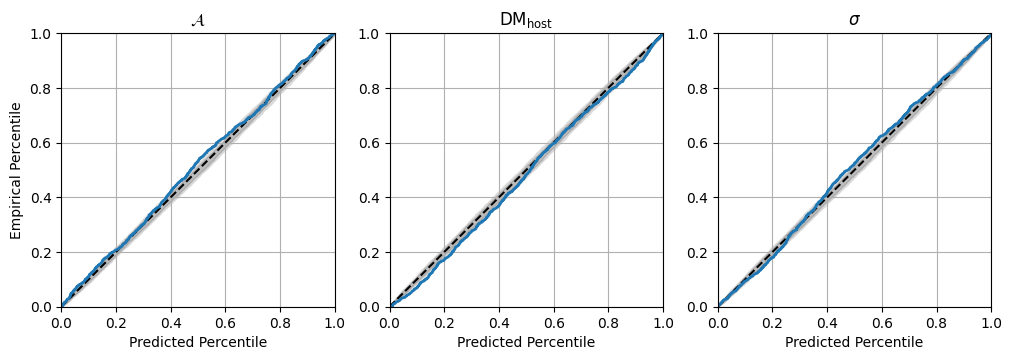

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.15it/s]




Type Fig: (<class 'list'>, <class 'matplotlib.figure.Figure'>)




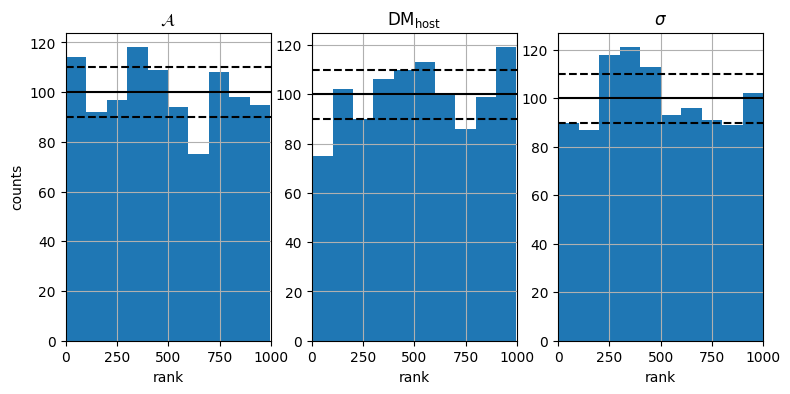

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.15it/s]




Type Fig: (<class 'list'>, <class 'matplotlib.figure.Figure'>)




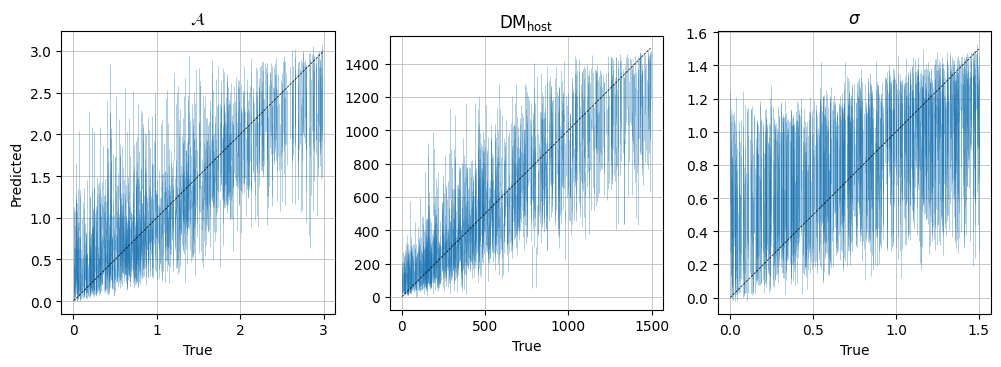

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.40it/s]




Type Fig: (<class 'list'>, <class 'matplotlib.figure.Figure'>)




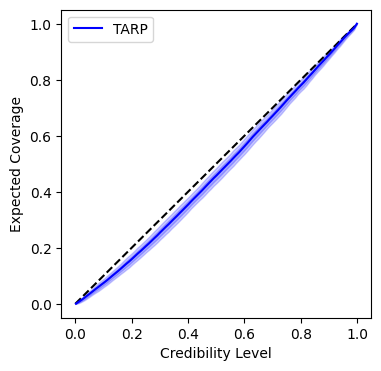



Complete, total time: 599.351 sec


In [21]:
inference_from_ili = sbi_instance.infer_ili(algorithm='TSNPE',
                                            num_sample=num_sample, 
                                            num_rounds=num_rounds, 
                                            num_sims_in_round=num_sims_in_round,
                                            num_walkers=num_walkers,
                                            compression=False,
                                            plot_figures=['contour', 'prior', 'likelihood', 'coverage_test', 'validation'],
                                            model_for_coverage=['ensemble'], #['ensemble', 'mdn', 'maf']
                                            coverage_list = ["coverage", "histogram", "predictions", "tarp"],
                                            save_data=True,
                                            verbose=False)

A brief explanation of the observations from the `iLi` package.
1. The first noticeable difference is the _truncation_ of the prior. This clearly shows the difference between `SNPE` and `TSNPE`.
   <br> This is what we want as we start with uninformative _uniform_ prior but gradually restrict the boundaries based on the highest probability region (HPR) of observing the data. This boosts the performance in the inference as we sample from a narrower prior.

3. The log-probability minimisation is significantly better as well. The noise can be further reduced if the number of rounds is higher.
   <br> The number of rounds is 2 here, which is visible in the log-probability plot. The noise in the $ \ 501-1000^{th}$ simulation is orders of magnitude better. Hence, a higher number of rounds is preferred. However, the corresponding number of simulations in each round should also scale so that the density estimator or neural network can learn properly.
   
5. The univariate coverage tests in PP, ranked histogram and prediction plots agree generally well, albeit with a slight hint of bias.
   <br> The diagonal line in the PP plot is what we are looking to achieve and the tiny deviations suggest we are biased. Ranked histogram checks for the coverage in the projection of the posterior. Loosely speaking, a _U_ shape indicates we are missing the coverage in the tail of the probability distribution function (PDF), whereas an _inverted U_ shape suggests the posterior has a higher variance or broader tails and misses the central portion. The prediction plot, as the name suggests, are prediction from the posterior. The spread is something we are looking for. If the blue lines were closer to the diagonal line, it would have hinted at poor prediction power as the network in that case learns from only very specific values of the parameters and cannot be extended.
   
7. The multivariate TARP coverage shows a higher overall bias and higher still in low credibility level.
   <br> The higher overall bias is expected as we check for multi-dimensional coverage. Univariate coverages take the projection of the final posterior, $p(\theta|x)$, before sampling and comparing to the observation. The projection, by definition, cannot capture the full complexity and we lose information. TAPR, on the other hand, checks for coverage with random points without projection. This preserves the dimensionality and shows the true bias.

The focus should be the diagonal line in TARP coverage and how close the model fits it. The biases can be minimised by increasing `NSIDE`.